<h2><center>Starter Code for IceBerg Detection</center></h2>

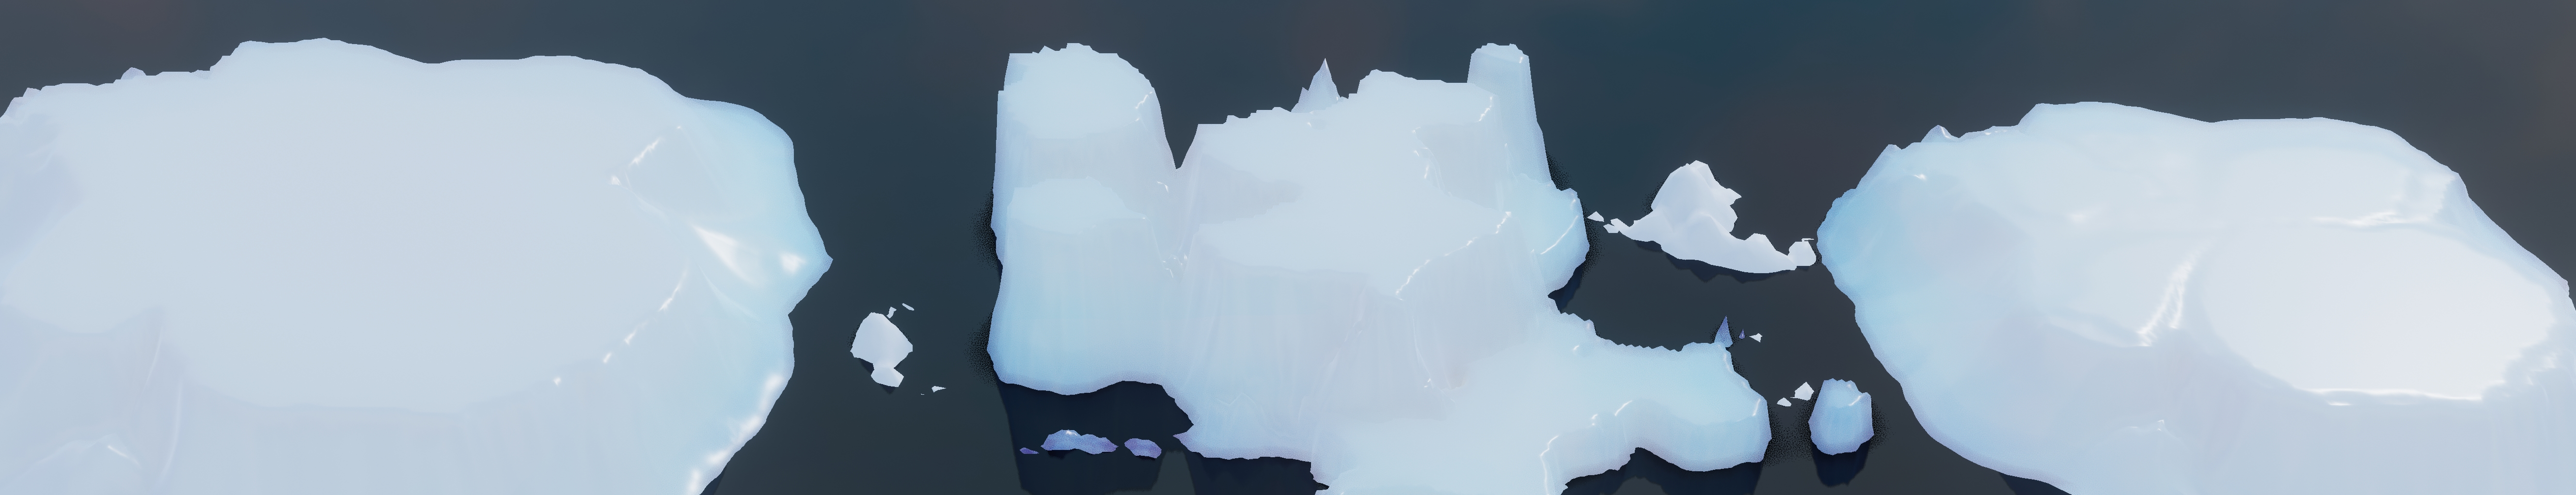
### What we are going to Learn

  - How to semantic segmentation using PyTorch.
  - Working with videos.
  - Testing and Submitting the Results to the Challenge. 

**Note : Create a copy of the notebook and use the copy for submission. Go to *File > Save a Copy in Drive* to create a new copy**

# Setup AIcrowd Utilities 🛠

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 170 kB 13.2 MB/s 
     |████████████████████████████████| 208 kB 14.4 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 8.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requ

## How to use this notebook? 📝

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data (The data will be available at `/data/` on aridhia workspace). This should be an absolute path.
`AICROWD_OUTPUTS_PATH` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#Install-packages-🗃) section to install the packages
- **Training your models**. All the code within the [Training phase ⚙️](#Training-phase-⚙️) section will be skipped during evaluation. **Please make sure to save your model weights in the assets directory and load them in the predictions phase section** 

## AIcrowd Runtime Configuration 🧷

Define configuration parameters. Please include any files needed for the notebook to run under `ASSETS_DIR`. We will copy the contents of this directory to your final submission file 🙂

The dataset is available under `/data` on the workspace.

In [ ]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/test.csv"`
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/data/test")
AICROWD_OUTPUTS_PATH = os.getenv("OUTPUTS_DIR", "")
AICROWD_ASSETS_DIR = os.getenv("ASSETS_DIR", "assets")

# Install packages 🗃

Installing PyTorch & some other libraries

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch pytorch-argus scikit-video natsort

# Installing Scikit Video & FFMPEG
!pip install scikit-video
!pip install ffmpeg
!apt-get install ffmpeg gstreamer1.0-libav vlc
!apt-get update -qq && sudo apt-get -y install \
  autoconf \
  automake \
  build-essential \
  cmake \
  git-core \
  libass-dev \
  libfreetype6-dev \
  libgnutls28-dev \
  libsdl2-dev \
  libtool \
  libva-dev \
  libvdpau-dev \
  libvorbis-dev \
  libxcb1-dev \
  libxcb-shm0-dev \
  libxcb-xfixes0-dev \
  meson \
  ninja-build \
  pkg-config \
  texinfo \
  wget \
  yasm \
  zlib1g-dev
!apt-get install ffmpeg libsm6  libxext6 -y
!pip install sk-video p-tqdm
!apt-get update
!apt-get install -y python3-opencv
!pip install --upgrade opencv
!pip install --upgrade torch torchvision

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ohjrwd9q
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ohjrwd9q
     |████████████████████████████████| 2.3 MB 10.6 MB/s 
     |████████████████████████████████| 58 kB 8.2 MB/s 
     |████████████████████████████████| 376 kB 57.4 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88681 sha256=25f7bf70a005a8cac86cc751b377ece3182e30c4db8c9c88b46d1d102a0f3773
  Stored in directory: /tmp/pip-ephem-wheel-cache-pqqbgxmy/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=8aa30a832e1279c14114a6fb9685431a71beac8f176d76fa216668db2deb9776
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel f

# Define preprocessing code 💻

The code that is common between the training and the prediction sections should be defined here. During evaluation, we completely skip the training section. Please make sure to add any common logic between the training and prediction sections here.

In [ ]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
import argus
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted
from glob import glob
import skvideo.io

# Training phase ⚙️

You can define your training code here. This sections will be skipped during evaluation.

## Downloading Dataset

Hre we are downloading the challange dataset using AIcrowd CLI 

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/QWEy5fOLpYgbEaM8eJXjcxrY9C-elZjxZxtzmYpdVeg
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c iceberg-detection -o data

test.zip:   0%|          | 0.00/513k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [ ]:
# Unzipping the files
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

### Dataloader

In [ ]:
class IcebergsSegmentationDataset(Dataset):
    
    def __init__(self, data_directory=None):
        

        self.data_directory = data_directory          

        # If the image direcotry is valid      
        if data_directory != None:
          self.image_videos_files = natsorted(glob(data_directory+"/image*"))
          self.segmentation_videos_files = natsorted(glob(data_directory+"/segmentation*"))

        self.img_list = list(zip(self.image_videos_files, self.segmentation_videos_files))

        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
      
      # Reading The oceberg video
      img_video = cv2.VideoCapture(self.img_list[idx][0]) 
      img_video.set(1, 15)

      ret, img = img_video.read()
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Reading the segmentation video
      seg_video = cv2.VideoCapture(self.img_list[idx][1])
      seg_video.set(1, 15)

      ret, mask = seg_video.read()

      img = np.array(img, dtype=np.float32)

      # Resizing the images
      img = cv2.resize(img, (128, 128))
      mask = cv2.resize(mask, (128, 128))

      img = np.expand_dims(img, axis=(0))  


      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      _, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

      return img, mask.astype(np.float32)

In [ ]:
# Creating the training dataset
train_dataset = IcebergsSegmentationDataset(data_directory="data/train")
train_loader = DataLoader(train_dataset, batch_size=23, num_workers=1, shuffle=False, drop_last=True)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([23, 1, 128, 128]), torch.Size([23, 128, 128]))

## Visualizing Dataset

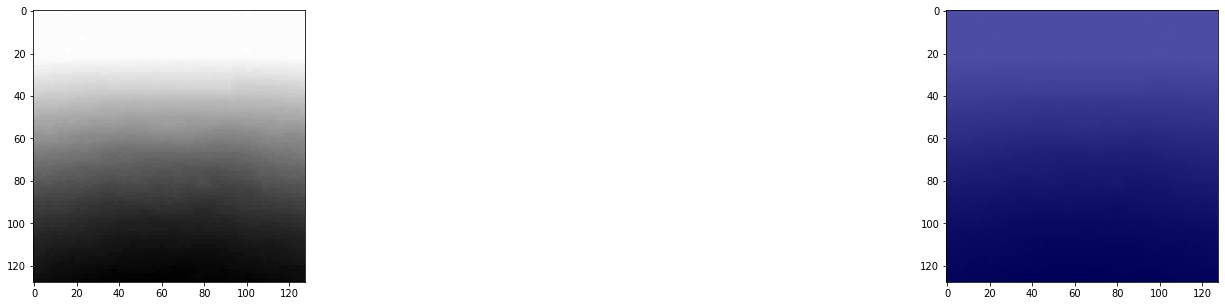

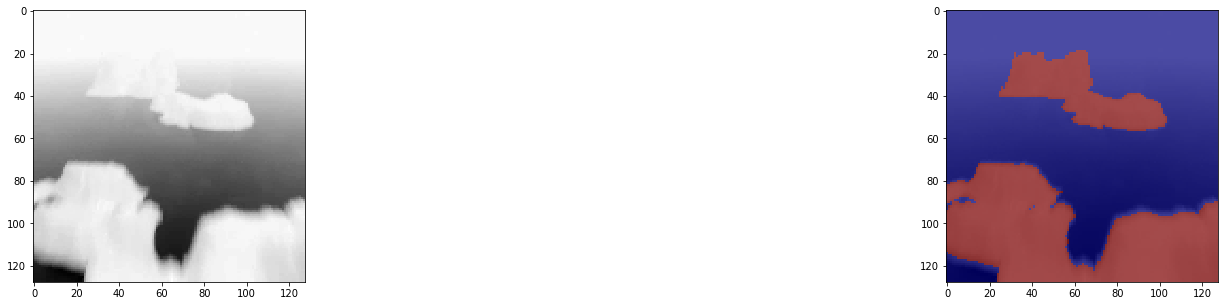

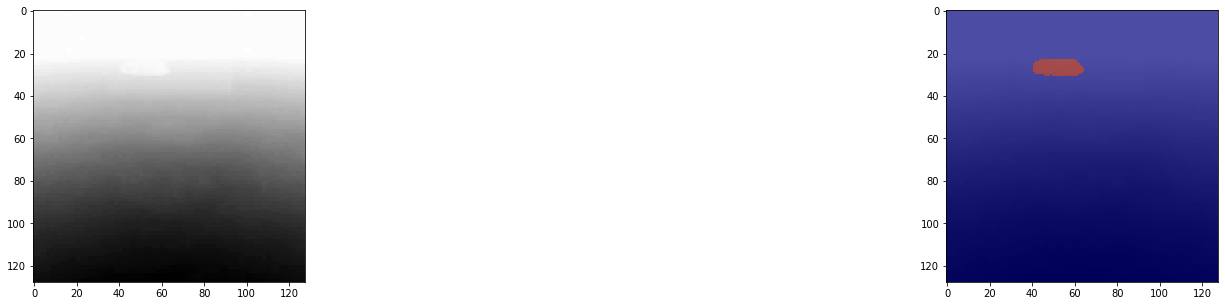

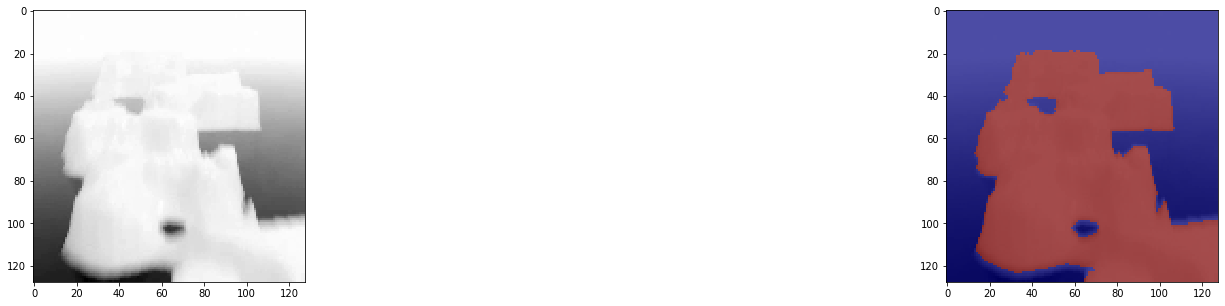

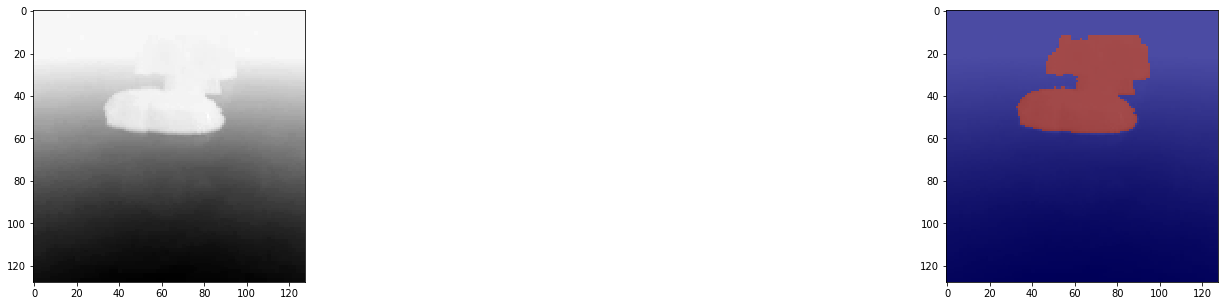

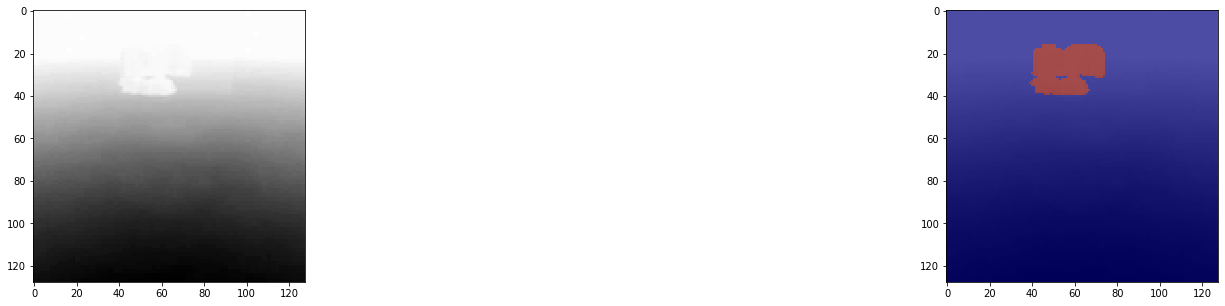

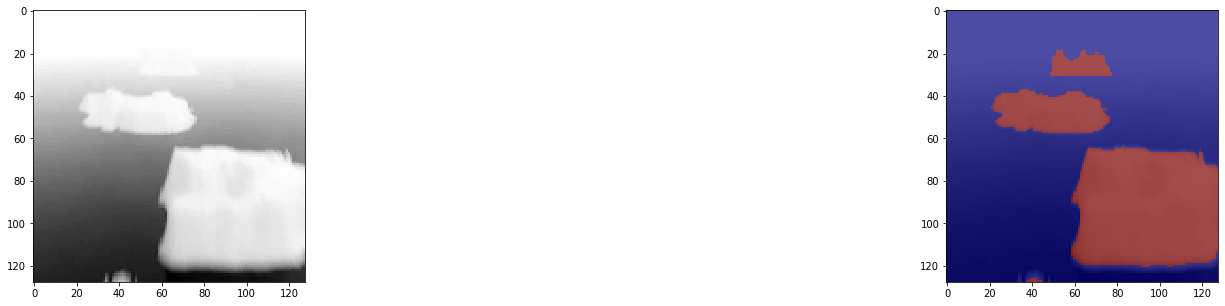

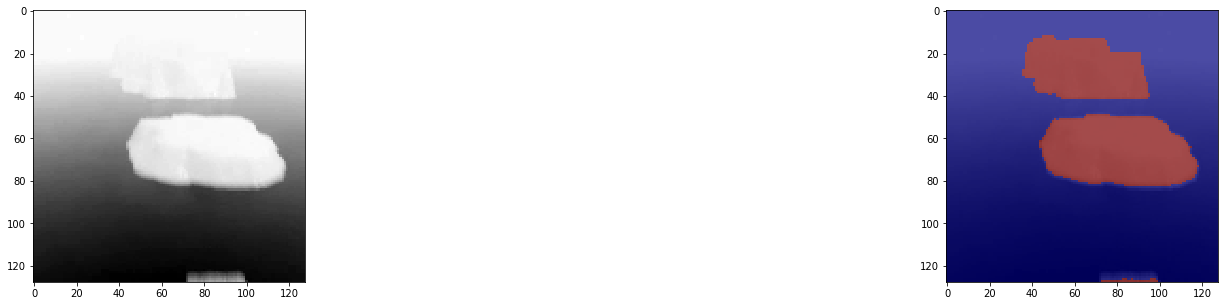

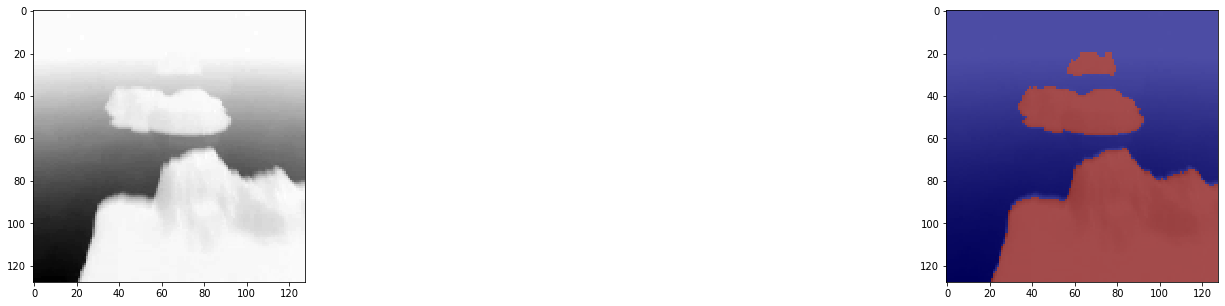

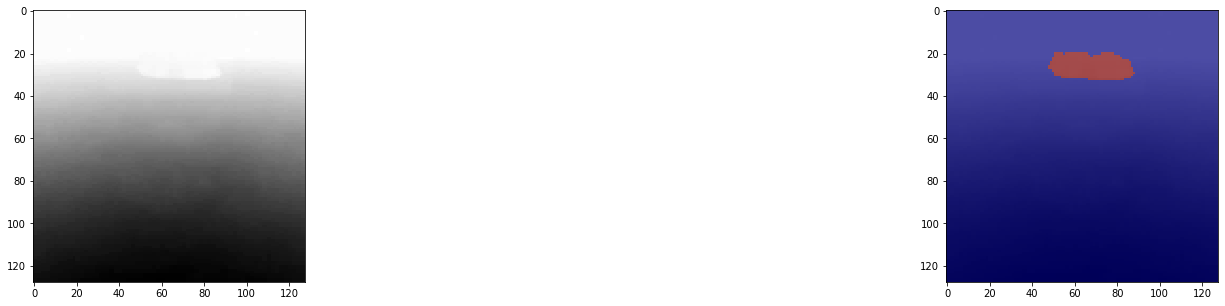

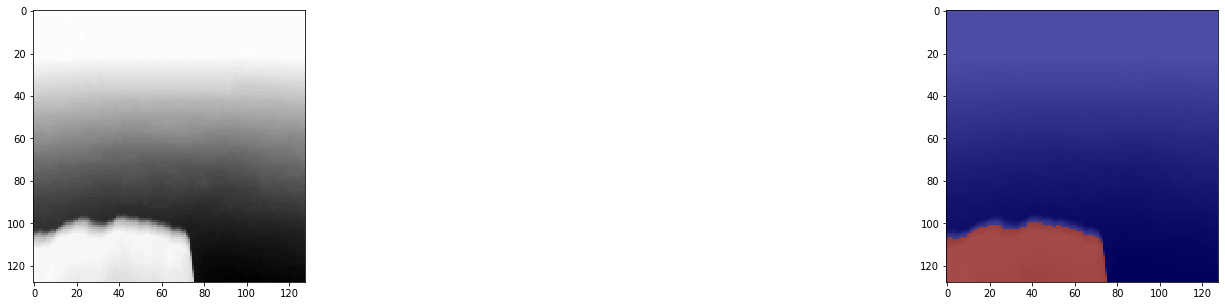

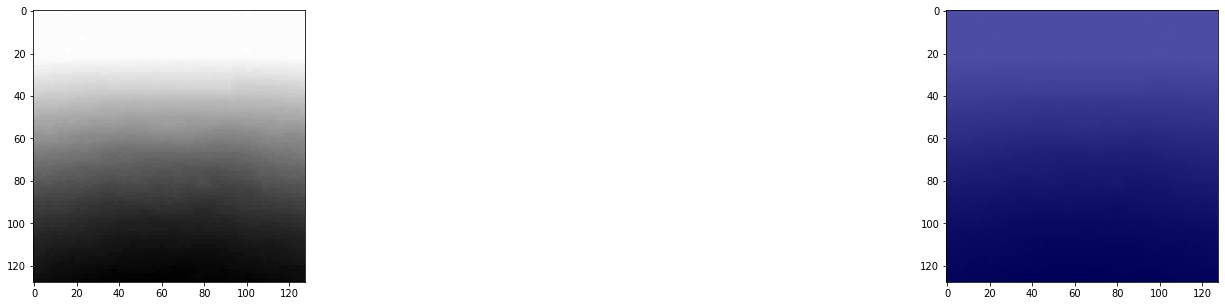

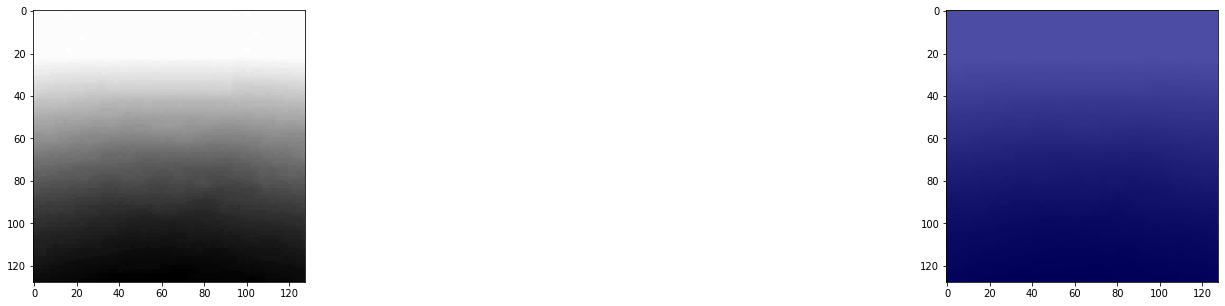

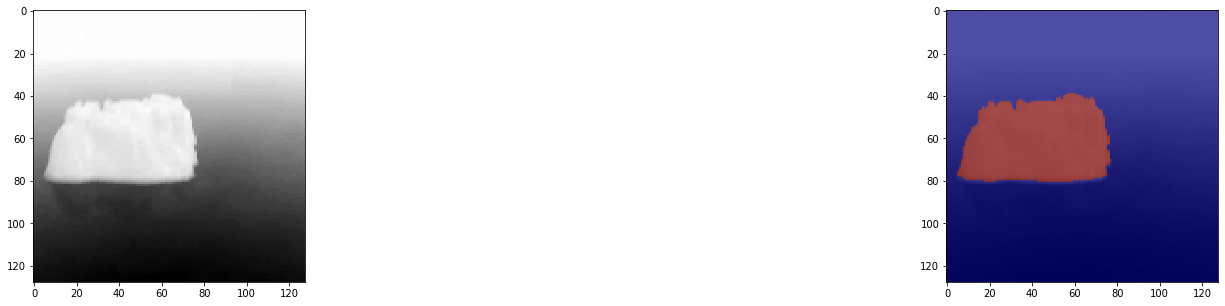

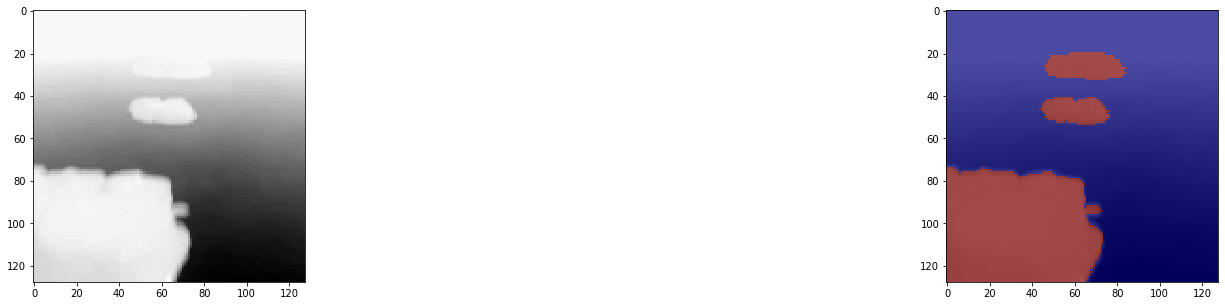

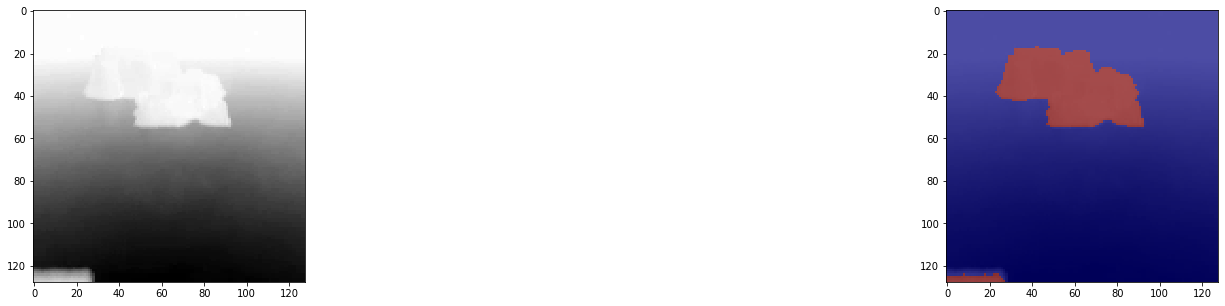

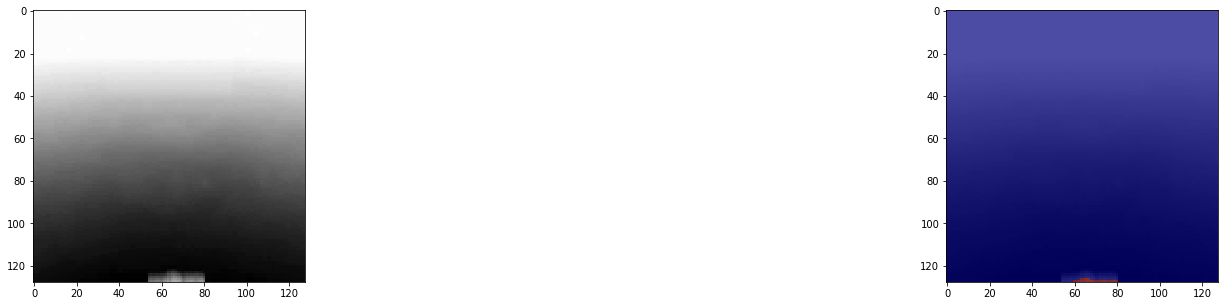

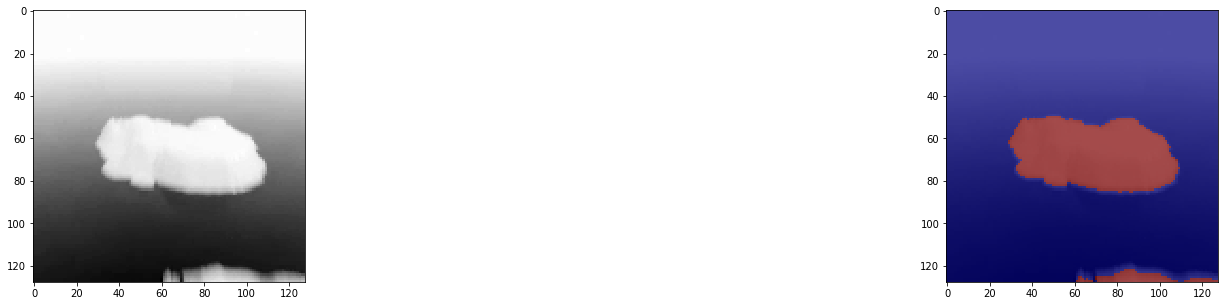

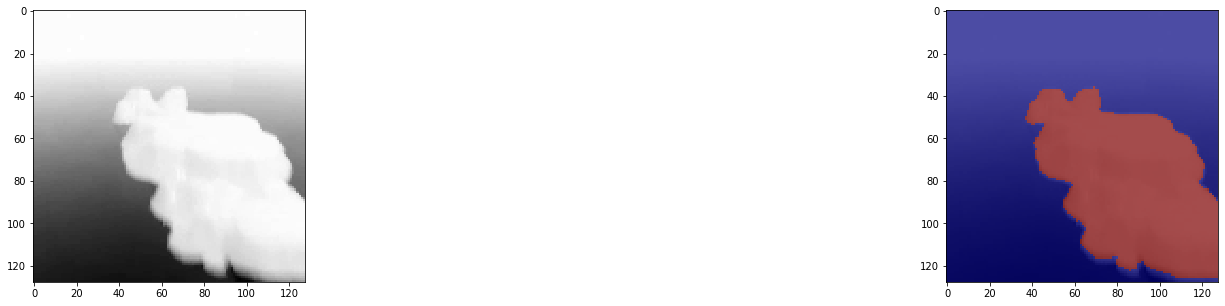

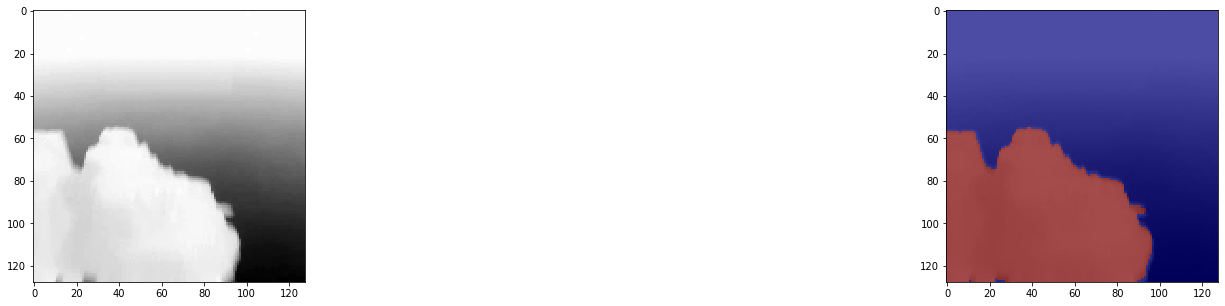

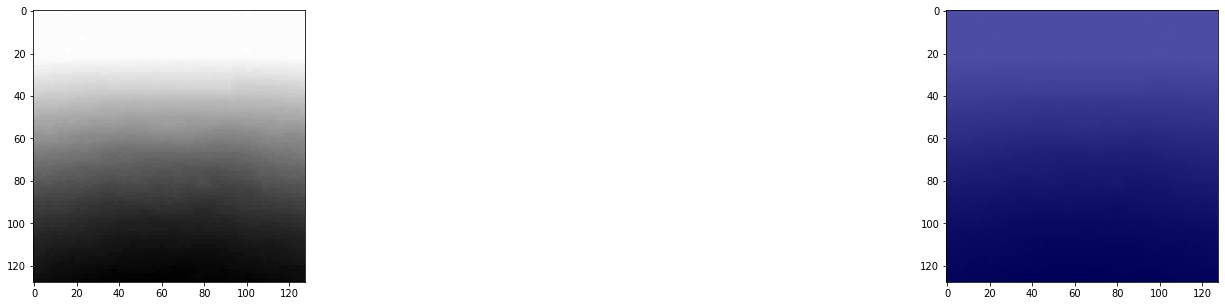

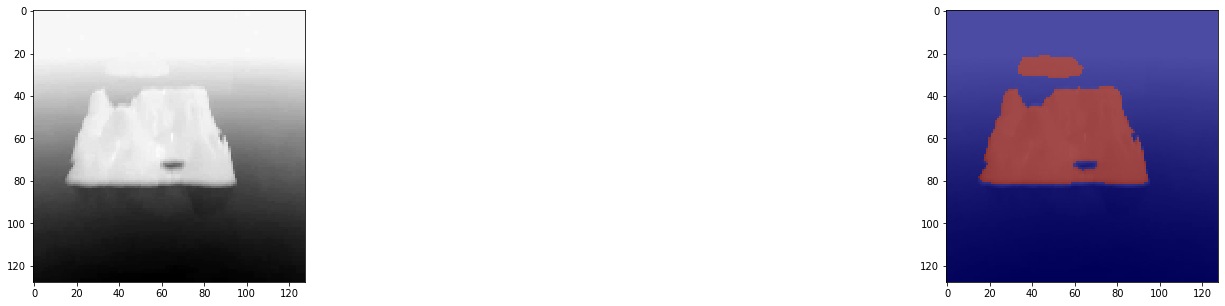

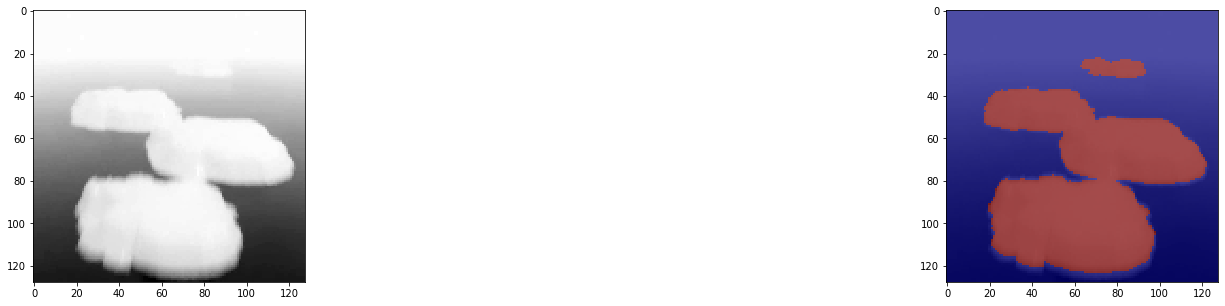

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

  image = image.numpy()[0]/255

  # Showing the image
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(image, 'gray', interpolation='none')
  plt.subplot(1,2,2)
  plt.imshow(image, 'gray', interpolation='none')
  plt.imshow(segmentation, 'jet', interpolation='none', alpha=0.7)
  plt.show()

## Creating the Model

Here we will get setting up the model architecture, optimizer and loss.

In [ ]:
class TressSegmentationModel(argus.Model):
    nn_module = smp.Unet
    optimizer = torch.optim.Adam
    loss =  nn.MSELoss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TressSegmentationModel({ 'device': device,
                                'nn_module': {
                                  'encoder_name': 'resnet18',
                                  'classes': 1,
                                  'in_channels': 1,
                                }})
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

{'params': {'device': 'cuda', 'nn_module': {'encoder_name': 'resnet18', 'classes': 1, 'in_channels': 1}}, 'logger': <Logger argus.model.build_140186540000848 (INFO)>, 'nn_module': Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): B

## Training the Model

In [ ]:
model.fit(train_loader,
      num_epochs=5,
      metrics=['accuracy'],
      metrics_on_train=True)  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([23, 128, 128])) that is different to the input size (torch.Size([23, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2021-07-24 07:18:29,386][INFO]: train - epoch: 0, lr: 0.001, train_loss: 9501.746, train_accuracy: 0.8479941


INFO     train - epoch: 0, lr: 0.001, train_loss: 9501.746, train_accuracy: 0.8479941

[2021-07-24 07:19:21,454][INFO]: train - epoch: 1, lr: 0.001, train_loss: 8682.995, train_accuracy: 0.8479941


INFO     train - epoch: 1, lr: 0.001, train_loss: 8682.995, train_accuracy: 0.8479941

[2021-07-24 07:20:14,207][INFO]: train - epoch: 2, lr: 0.001, train_loss: 7922.031, train_accuracy: 0.8479941


INFO     train - epoch: 2, lr: 0.001, train_loss: 7922.031, train_accuracy: 0.8479941

[2021-07-24 07:21:06,596][INFO]: train - epoch: 3, lr: 0.001, train_loss: 7640.658, train_accuracy: 0.8479941


INFO     train - epoch: 3, lr: 0.001, train_loss: 7640.658, train_accuracy: 0.8479941

[2021-07-24 07:21:58,710][INFO]: train - epoch: 4, lr: 0.001, train_loss: 7566.912, train_accuracy: 0.8479941


INFO     train - epoch: 4, lr: 0.001, train_loss: 7566.912, train_accuracy: 0.8479941

## Visualize Predictions

In [ ]:
predictions = model.predict(image_batch)
predictions.shape

torch.Size([23, 1, 128, 128])

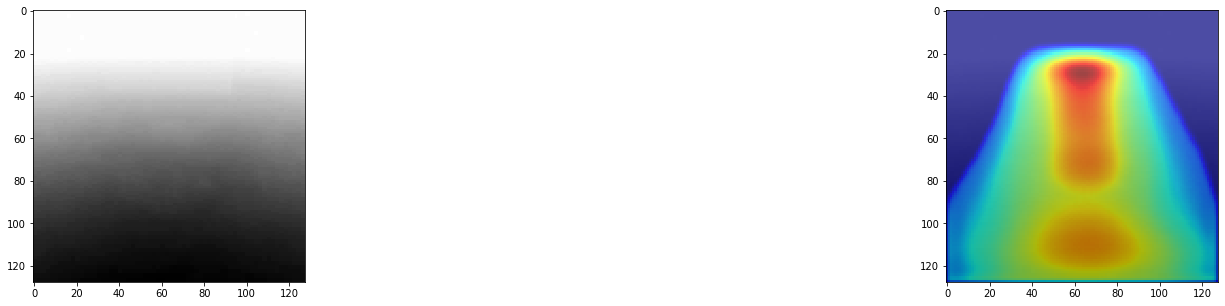

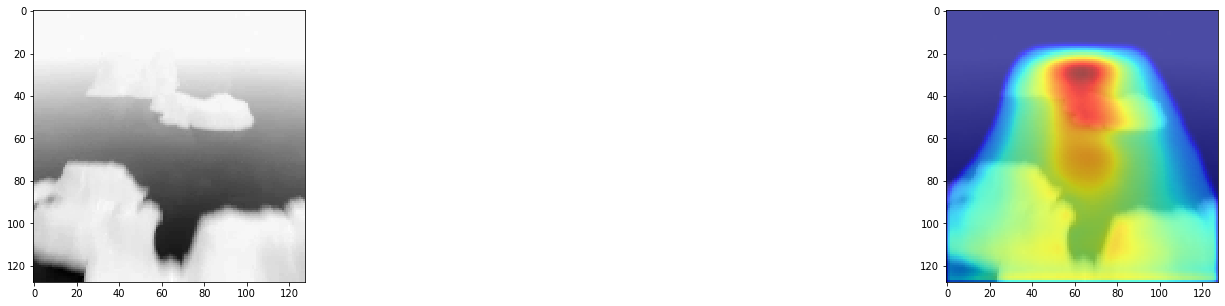

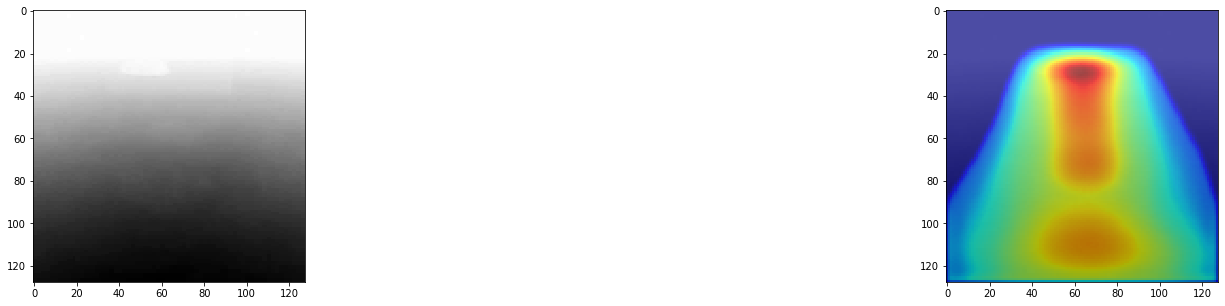

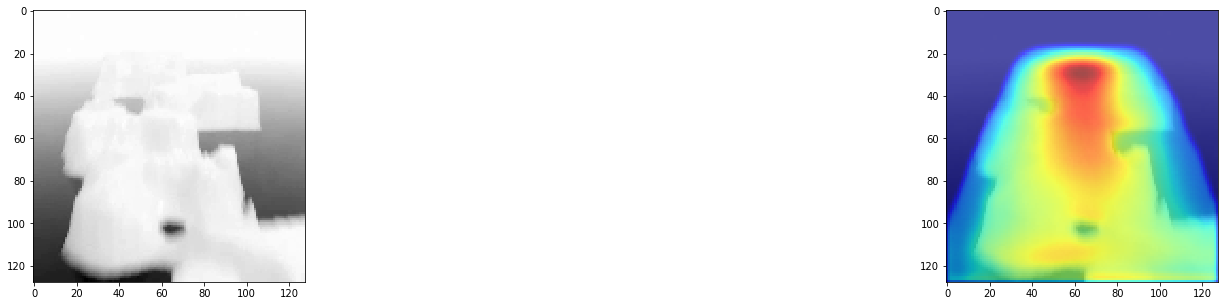

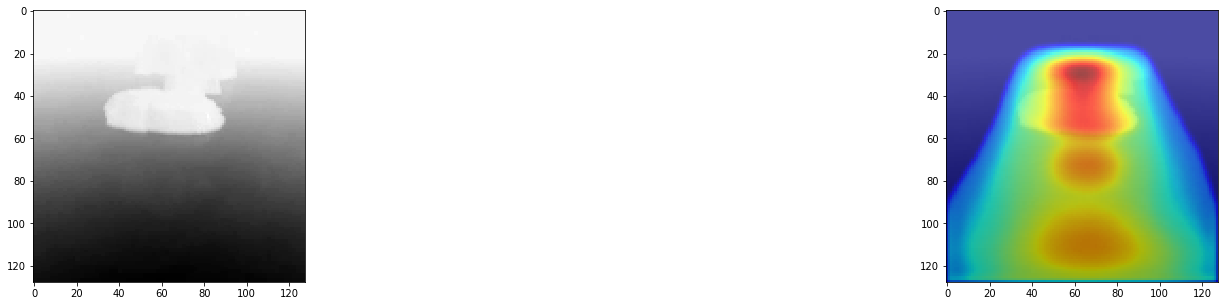

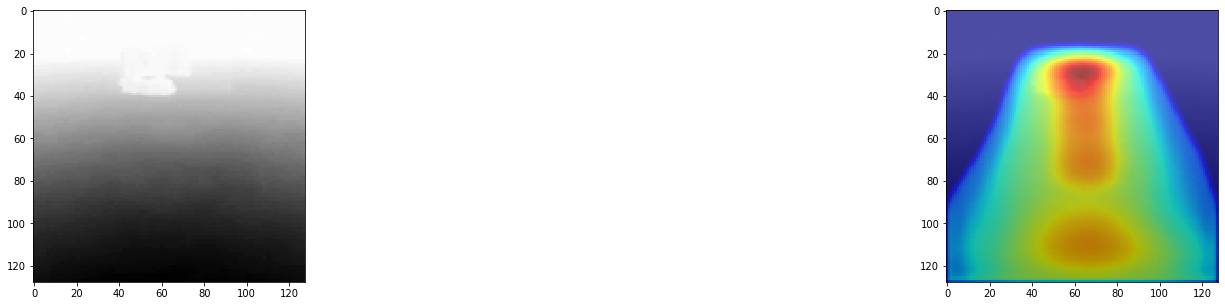

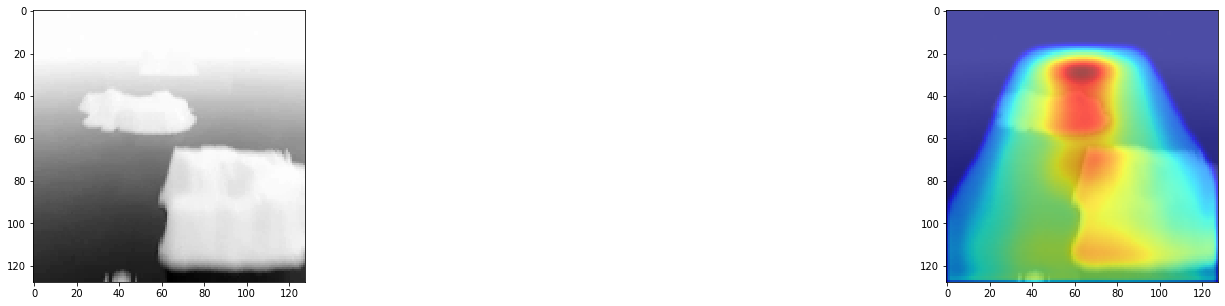

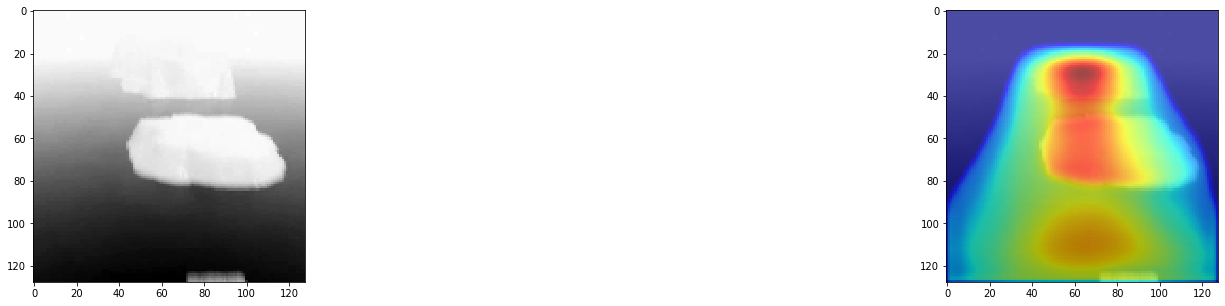

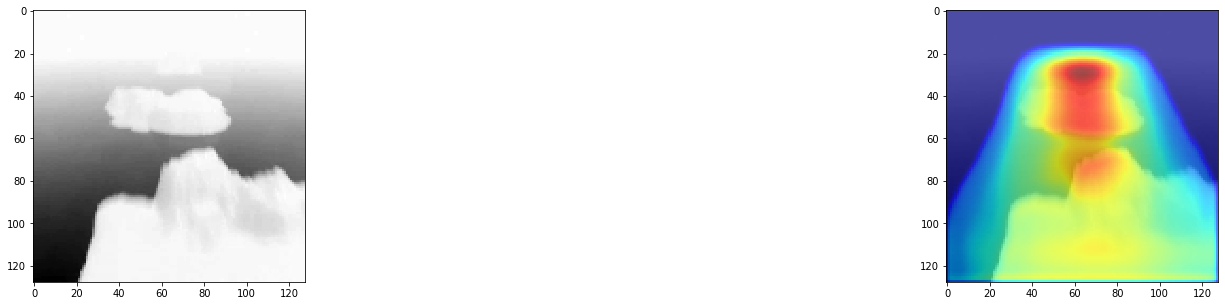

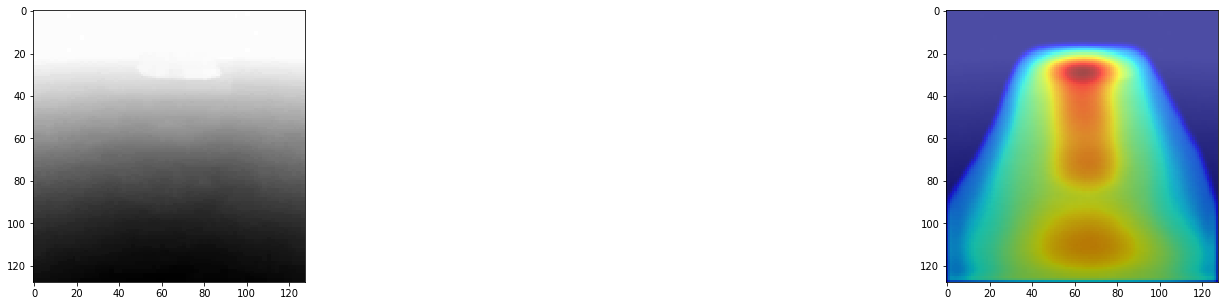

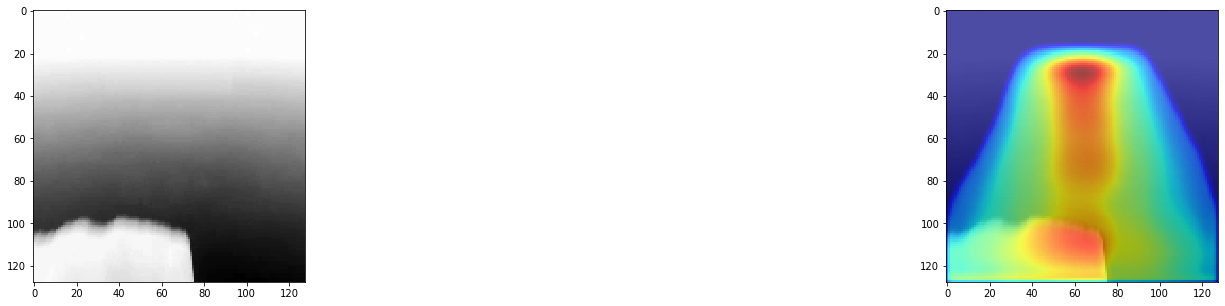

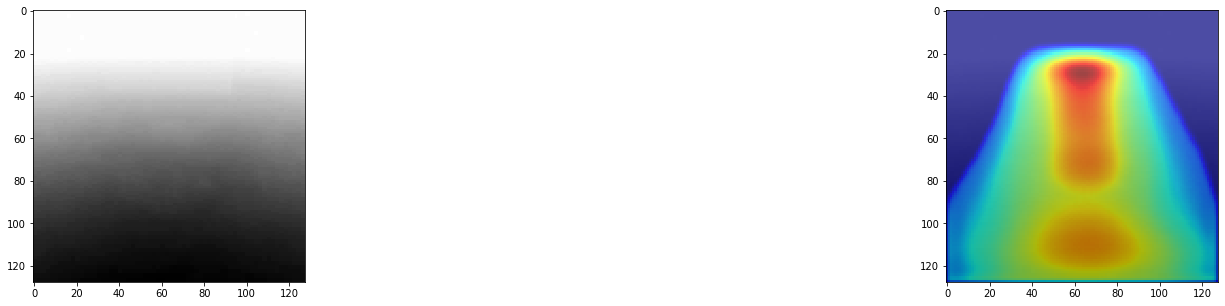

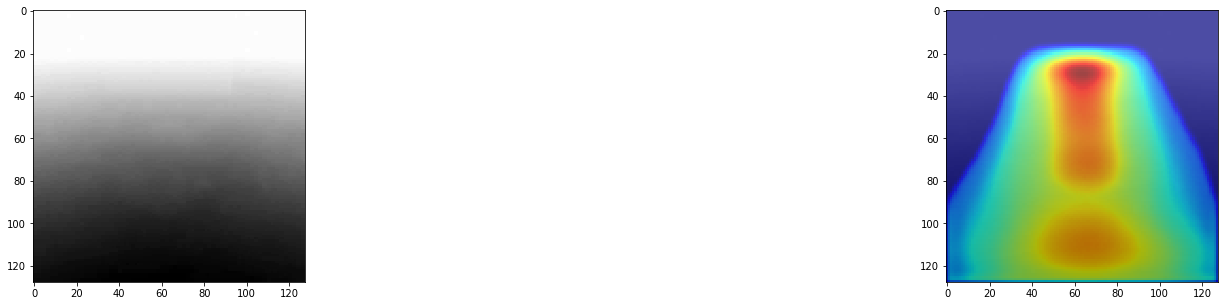

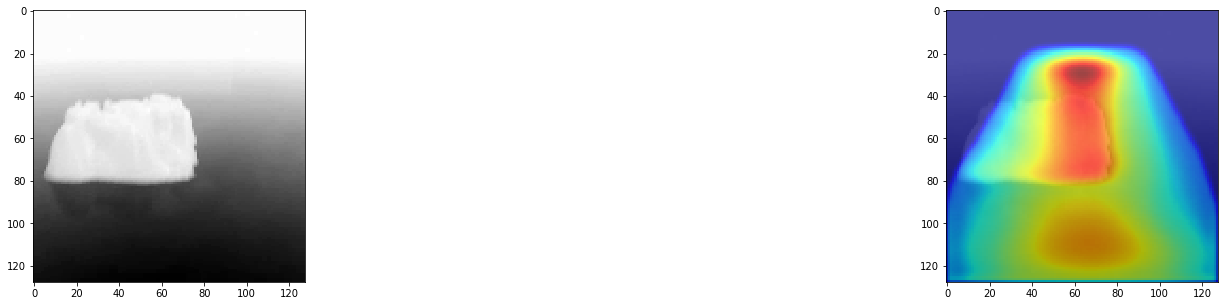

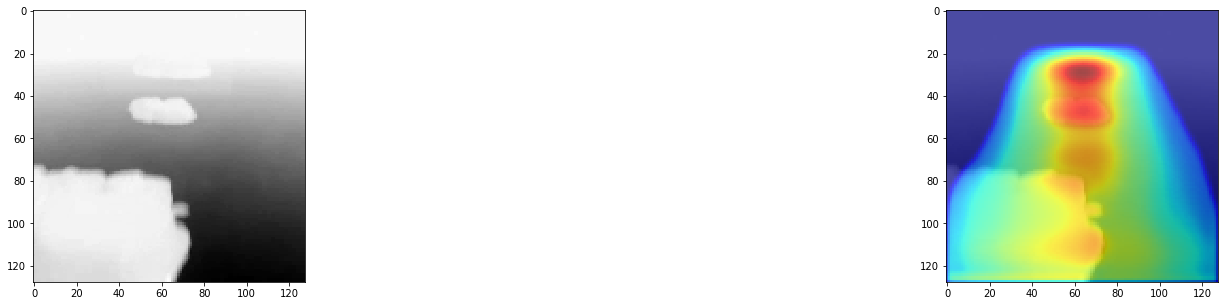

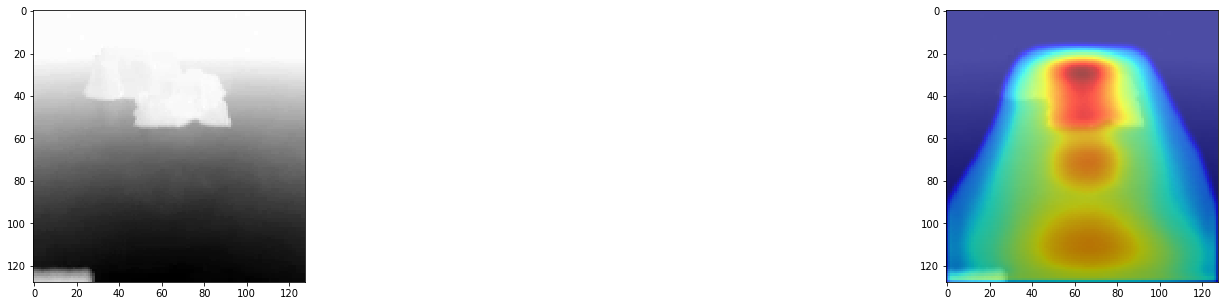

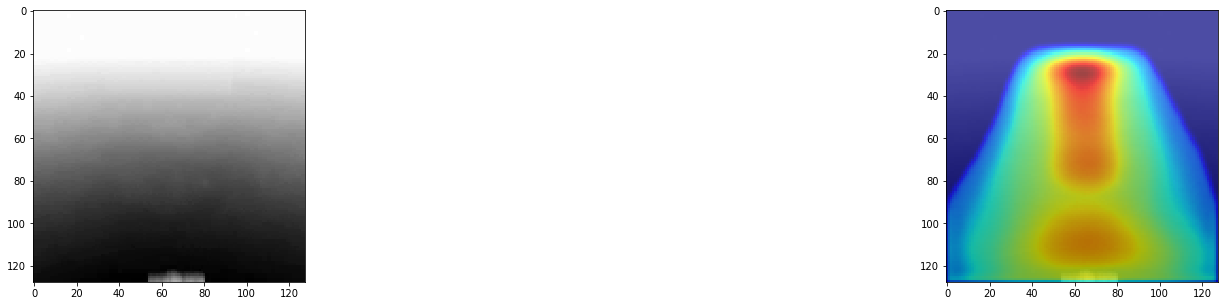

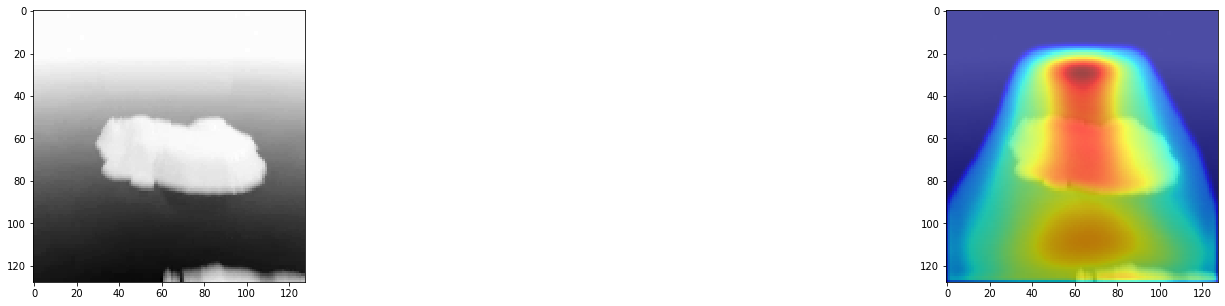

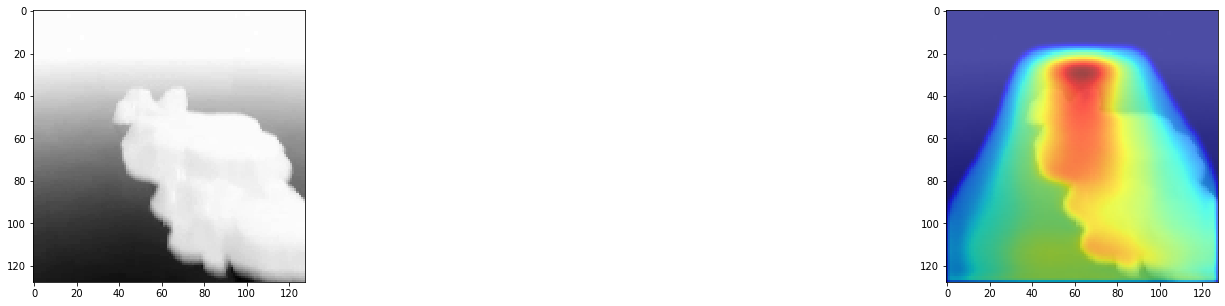

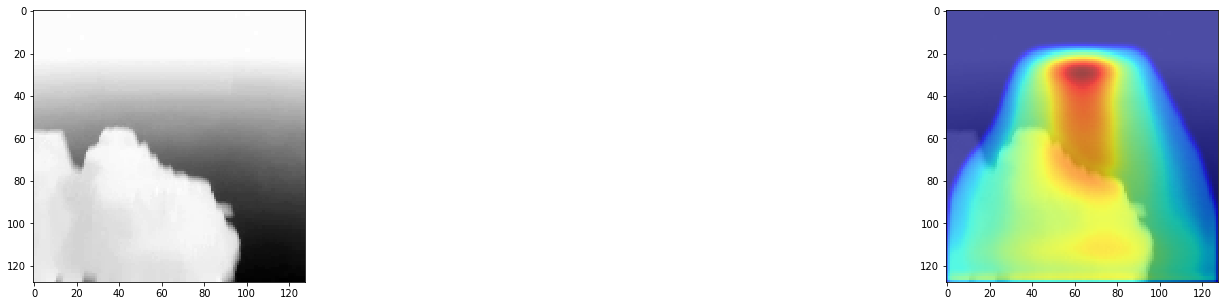

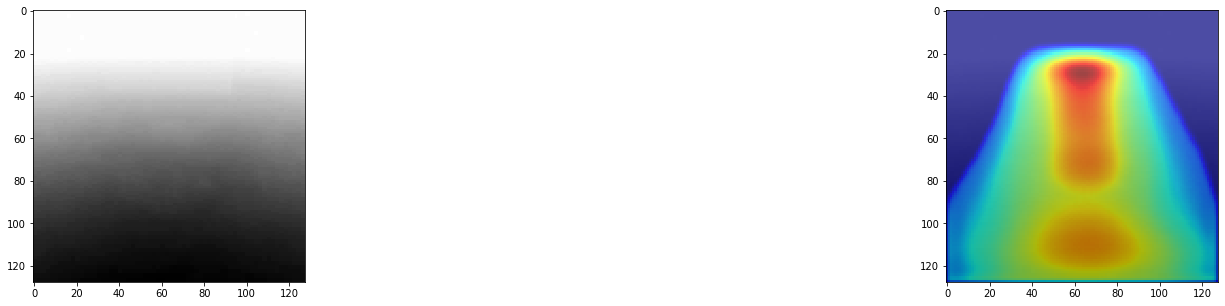

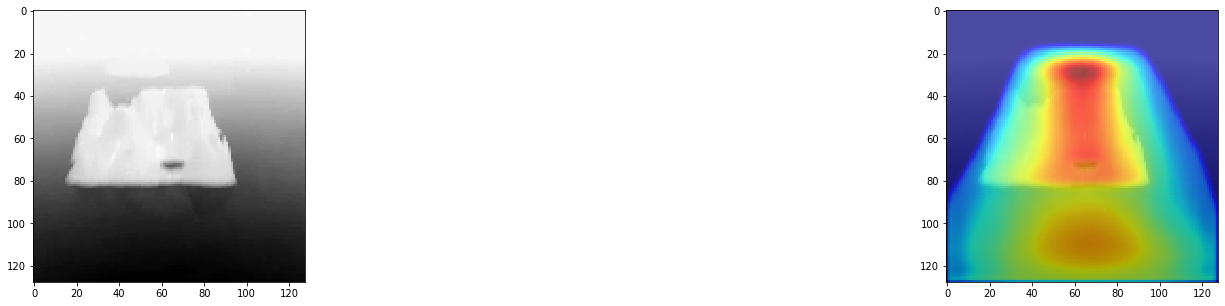

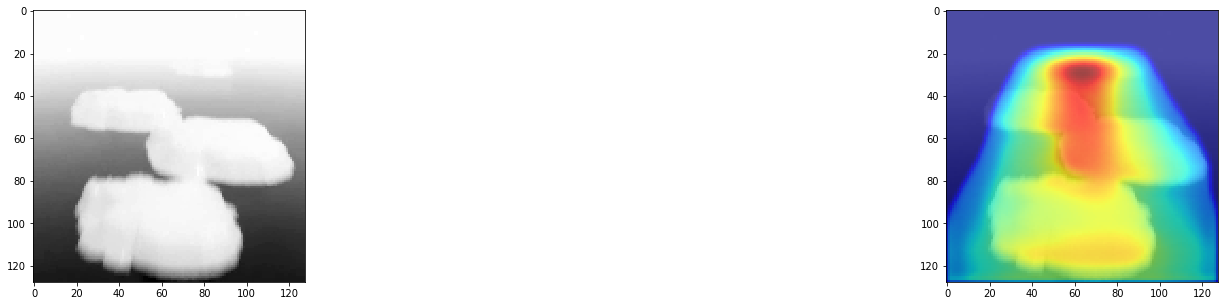

In [ ]:
# Going through each image and segmentation
for image, segmentation in zip(image_batch, predictions.cpu()):

  image = image.numpy()[0]/255

  # Showing the image
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(image, 'gray', interpolation='none')
  plt.subplot(1,2,2)
  plt.imshow(image, 'gray', interpolation='none')
  plt.imshow(segmentation[0], 'jet', interpolation='none', alpha=0.7)
  plt.show()

## Saving the Model

In [ ]:
!mkdir assets
torch.save(model, os.path.join("assets", "model.h5"))

# Prediction phase 🔎

Generating the features in test dataset. 

## Loading the Model

In [ ]:
device = torch.device("cpu")

In [ ]:
class TressSegmentationModel(argus.Model):
    nn_module = smp.Unet
    optimizer = torch.optim.Adam
    loss =  nn.MSELoss

/usr/local/lib/python3.7/dist-packages/argus/model/build.py:96: UserWarning: <class '__main__.TressSegmentationModel'> redefined 'TressSegmentationModel' that was already registered by <class '__main__.TressSegmentationModel'>
  warnings.warn(f"{current_class} redefined '{name}' "


In [ ]:
model = torch.load(os.path.join("assets", "model.h5"), map_location=torch.device('cpu'))
model

{'params': {'device': 'cuda', 'nn_module': {'encoder_name': 'resnet18', 'classes': 1, 'in_channels': 1}}, 'logger': <Logger argus.model.build_140186540000848 (INFO)>, 'nn_module': Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): B

In [ ]:
# Test Dataloader Class
class IcebergsSegmentationTestDataset(Dataset):
    
    def __init__(self, data_directory=None):
        
      self.data_directory = data_directory          

      # If the image direcotry is valid      
      if data_directory != None:
        self.image_videos_files = natsorted(glob(os.path.join(data_directory, "image")+"*"))

      self.img_list = self.image_videos_files
        
    def __len__(self):
      
      # Number of test images * Number of frame 
      return len(self.img_list)*23

    def __getitem__(self, idx):
      
      # Reading the Video
      img_video = cv2.VideoCapture(self.img_list[idx//23]) 
      
      # Reading the specific frame of the video
      img_video.set(1, idx%23)

      ret, img = img_video.read()
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Chaning the dtype
      img = np.array(img, dtype=np.float32)

      # Resizing the image
      img = cv2.resize(img, (128, 128))

      img = np.expand_dims(img, axis=(0))  

      return img

In [ ]:
test_dataset = IcebergsSegmentationTestDataset(data_directory=AICROWD_DATASET_PATH)
test_loader = DataLoader(test_dataset, batch_size=23, num_workers=1, shuffle=False, drop_last=False)

# Reading the image and corrosponding segmentation
image_batch = next(iter(test_loader))
image_batch.shape

torch.Size([23, 1, 128, 128])

In [ ]:
# Generating Predictions Function
def gen_predictions(test_loader, model, AICROWD_OUTPUTS_PATH):

  for batch_idx, image_batch in tqdm(enumerate(test_loader)):

    model.nn_module = model.nn_module.to("cpu")
    image_batch = image_batch.to("cpu")

    predictions = model.nn_module.predict(image_batch)

    writer = skvideo.io.FFmpegWriter(os.path.join(AICROWD_OUTPUTS_PATH,  f"segmentation_{batch_idx}.mp4"), outputdict={
                '-vcodec': 'libx264',  
                '-crf': '0',           
                '-preset':'veryslow'   
                })


    for seg in predictions:
      
      seg_np = seg[0].numpy()

      # Setting a threshold to get the segmentation in some parts 
      _, seg_np = cv2.threshold(seg_np,50,255,cv2.THRESH_BINARY)

      # Resizing the video
      seg_np = cv2.resize(seg_np, (512, 512))
      
      writer.writeFrame(seg_np.astype(np.uint8))

    writer.close()

## Generating the Predictions

In [ ]:
gen_predictions(test_loader, model, AICROWD_OUTPUTS_PATH)

0it [00:00, ?it/s]

# Submit to AIcrowd 🚀¶

In [ ]:
!aicrowd -v notebook submit --assets-dir assets --challenge iceberg-detection --no-verify

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgPQ0zS1ghOY-3UhCZCyusdasxuyJNX2o04rSeYa1PcXBhazTwFJvU
Mounted at /content/drive
Using notebook: /content/drive/MyDrive/Colab Notebooks/Icebergs Unet for submission...
Scrubbing API keys from the notebook...
Valida

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-10/problems/icebergs-detection/discussion) or in [AIcrowd Discord server](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 